# **PART B**: Multi-class classification using a pretrained Deep Learning model



## - For this application **ResNet50v2** is used


### **WARNING**: The code block below is an optional step. Run it if the database is stored on your drive, otherwise skip this block. Remember to change the zip_path directory accordingly should you run it.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Change path accordingly if data is saved in your Drive
zip_path = '/content/gdrive/MyDrive/CV_3/imagedb_btsd.zip'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **1)** Unzip the data folder.
COMMENT: Uncomment the zip_path directory if database is stored locally.

In [ ]:
import os
import zipfile

# # Uncomment zip_path, if data is saved locally
# zip_path = 'imagedb_btsd.zip'

zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

### **2)** Calculate average (max) dimension and average aspect ratio in train (and validation) data.

In [ ]:
import numpy as np
import cv2

train_dir = 'imagedb'

folder_max_dim = []
folder_aspect_ratio = []
train_folders = os.listdir(train_dir)

for folder in train_folders:
    train_folder = os.path.join(train_dir, folder)
    files = os.listdir(train_folder)
    file_max_dim = []
    file_aspect_ratio = []

    for file in files:
        path = os.path.join(train_folder, file)
        img_shape = (cv2.imread(path)).shape
        file_max_dim.append(max(img_shape))
        file_aspect_ratio.append(img_shape[1]/img_shape[0])

    total_folder_files = len(file_max_dim)
    folder_max_dim.append(sum(file_max_dim)/total_folder_files)
    folder_aspect_ratio.append(sum(file_aspect_ratio)/total_folder_files)

total_classes = len(folder_max_dim)
train_dim = round((sum(folder_max_dim)/total_classes))
train_aspect_ratio = sum(folder_aspect_ratio)/total_classes

print("The average (max) dimension in train (and validation) data is: %d" % train_dim)
print("The average aspect ratio in train (and validation) data is: %.2f" % train_aspect_ratio)

The average (max) dimension in train (and validation) data is: 132
The average aspect ratio in train (and validation) data is: 0.94


### **3)** Print an image from the training data to ensure that the unziping was successful.

A plotted image to ensure successful operation:



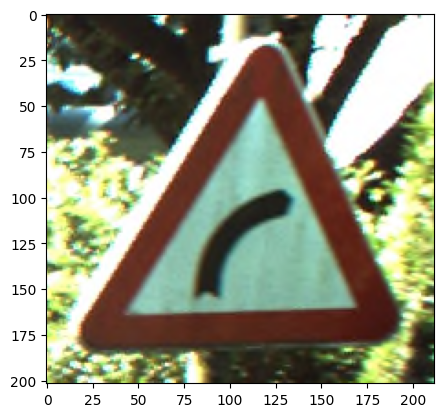

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = "imagedb/00004"
files = os.listdir(img_path)
img_path = os.path.join(img_path, files[0])
img = mpimg.imread(img_path)
plt.imshow(img)

print("A plotted image to ensure successful operation:")
print()
plt.show()

### **4)** Load the **ResNet50V2** model

In [ ]:
from keras.applications import ResNet50V2

# Define size of images entering the network
input_img = 256
#Load the ResNet50V2 model
ResNet50V2_conv =ResNet50V2(weights='imagenet',
                 include_top=False,
                 input_shape=(input_img, input_img, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### **5)** Freeze (make untrainable) and view layers of **ResNet50v2**

In [ ]:
# Freeze the layers except the last 4 layers
for layer in ResNet50V2_conv.layers[:-4]:
    layer.trainable = False

layers_ResNet50v2 = ResNet50V2_conv.layers
print("ResNet50v2 is made of %d layers (2 top layers not included)." % len(layers_ResNet50v2))
print("The layers are:")
print()

# Check the trainable status of the individual layers
for layer in layers_ResNet50v2:
     print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<BatchNormalization name=conv2_block1_preact_bn, built=True> False
<Activation name=conv2_block1_preact_relu, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<ZeroPadding2D name=conv2_block1_2_pad, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<Add name=conv2_block1_out, built=True> False
<BatchNormalization name=conv2_block2_preact_bn, built=True> False
<Activation name=co

### **6)** Add the final layers to the **ResNet50V2** convolutional base model

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the ResNet50V2 convolutional base model
model.add(ResNet50V2_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(total_classes, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 8, 8, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     134,218,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 34)                  │          34,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,818,402 (602.03 MB)

 Trainable params: 135,308,322 (516.16 MB)

 Non-trainable params: 22,510,080 (85.87 MB)

### **7)** Preprocess and load image data for training and validation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    # color_mode='grayscale',
                                                    target_size=(input_img,input_img),
                                                    shuffle=False,
                                                    # seed=1,
                                                    subset='training')
# --------------------
# Flow validation images in batches of 20 using train_datagen generator
# --------------------
validation_generator =  train_datagen.flow_from_directory(train_dir,
                                                        batch_size=20,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                        target_size=(input_img,input_img),
                                                        # seed=1,
                                                        subset='validation')

Found 2767 images belonging to 34 classes.
Found 289 images belonging to 34 classes.


### **8)** Train and validate the model.

In [ ]:
import tensorflow as tf

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

callbacks = []

save_best_callback = tf.keras.callbacks.ModelCheckpoint(f'best_weights.keras', save_best_only=True, verbose=1)
callbacks.append(save_best_callback)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
callbacks.append(early_stop_callback)


# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      verbose=1,
      callbacks=callbacks)

# Save the model
model.save('my_model_pre.keras')
print()
print()
print("### Model saved successfully as my_model_pre.keras ###")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3203 - loss: 6.5787
Epoch 1: val_loss improved from inf to 0.57180, saving model to best_weights.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - accuracy: 0.3215 - loss: 6.5578 - val_accuracy: 0.8097 - val_loss: 0.5718
Epoch 2/100
  1/138 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.8000 - loss: 0.6989

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.57180
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8000 - loss: 0.6989 - val_accuracy: 0.8028 - val_loss: 0.6017
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8785 - loss: 0.4453
Epoch 3: val_loss improved from 0.57180 to 0.17028, saving model to best_weights.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8788 - loss: 0.4443 - val_accuracy: 0.9481 - val_loss: 0.1703
Epoch 4/100
  1/138 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9500 - loss: 0.1140
Epoch 4: val_loss improved from 0.17028 to 0.16962, saving model to best_weights.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9500 - loss: 0.1140 - val_accuracy: 0.9481 - val_loss: 0.1696
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9888 - loss: 0.0413
Epoch 5: val_loss improved from 0.16962 to 0.09629, saving model to best_weights.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.9888 - loss: 0

### **9)** Plot accuracy and loss of the model during training and validation.

### Plot of Accuracy over epochs ###



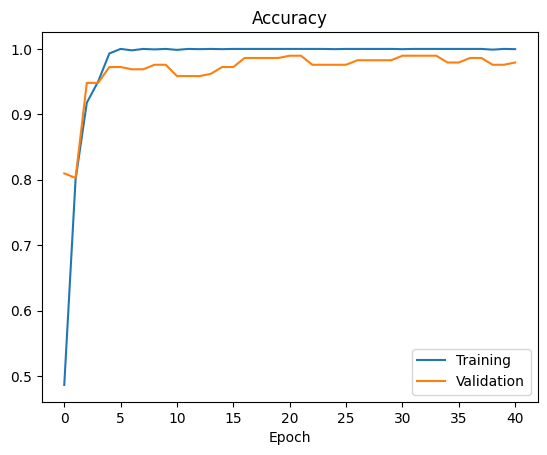


### Plot of Loss over epochs ###



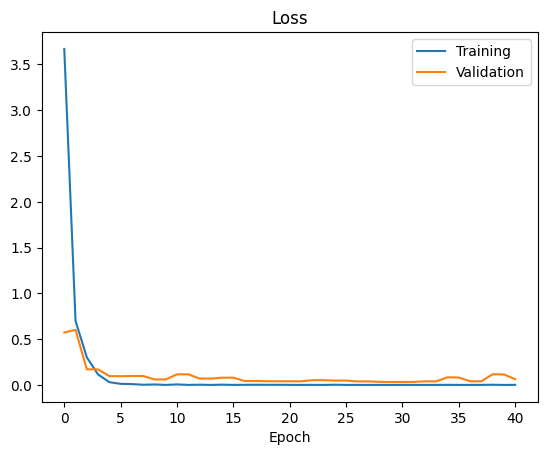

In [ ]:
print("### Plot of Accuracy over epochs ###")
print()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()
print()

print("### Plot of Loss over epochs ###")
print()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### **10)** Test the produced model on new (different) data.

In [ ]:
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_dir = 'imagedb_test'
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=25,
                                                  class_mode='categorical',
                                                  # color_mode='grayscale',
                                                  target_size=(input_img,input_img))
loss, acc = model.evaluate(test_generator)
print()
print("### TESTING RESULTS ###")
print()
print("The model has achieved:")
print("- Accuracy: %.3f => %.1f%%" % (acc, 100 * acc))
print("- Loss: %.3f => %.1f%%" % (loss, 100 * loss))

Found 2149 images belonging to 34 classes.
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9585 - loss: 0.1513

### TESTING RESULTS ###

The model has achieved:
- Accuracy: 0.960 => 96.0%
- Loss: 0.166 => 16.6%


### **11)** RESULT VISUALIZATION: Test the model on test images (view softmax output).

### Result Visualization ###

The image below has been input to the produced model:



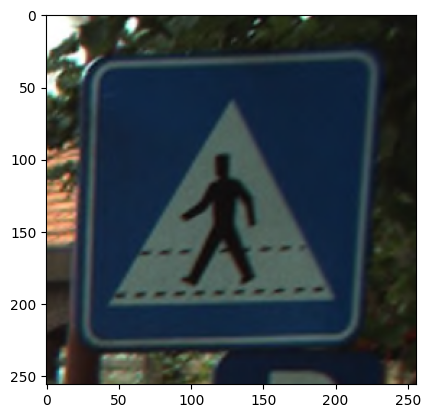

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax Ou

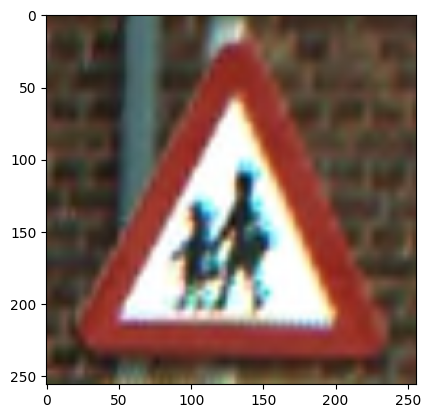

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 100.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

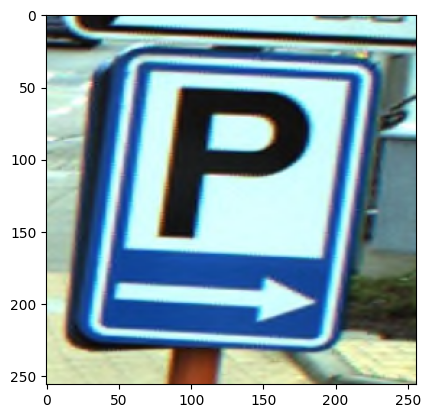

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax 

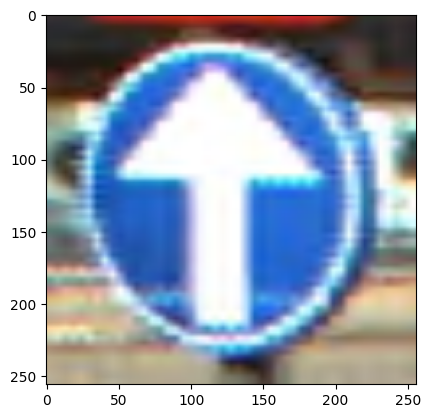

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 100.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

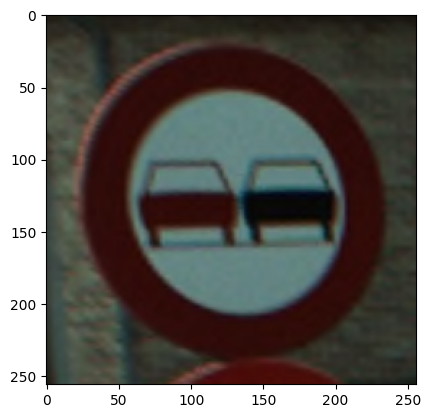

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 100.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

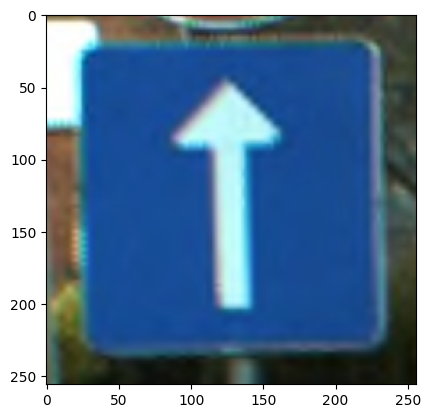

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax 

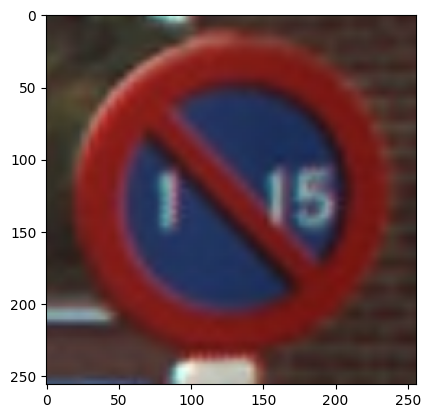

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.1%
24) 00042 => Softmax Output: 98.9%
25) 00043 => Softmax Output: 1.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

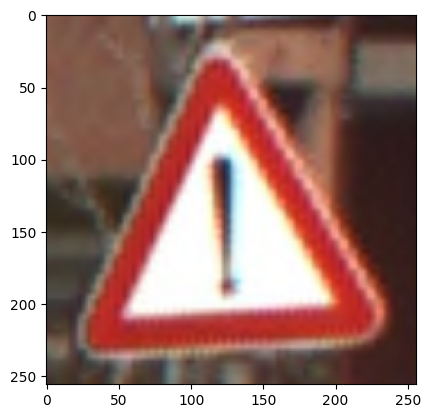

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 100.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

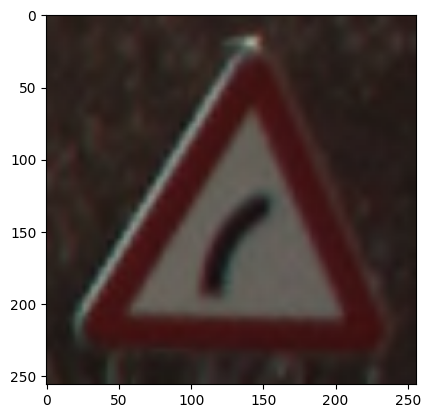

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.1%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.3%
8) 00017 => Softmax Output: 99.4%
9) 00018 => Softmax Output: 0.2%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

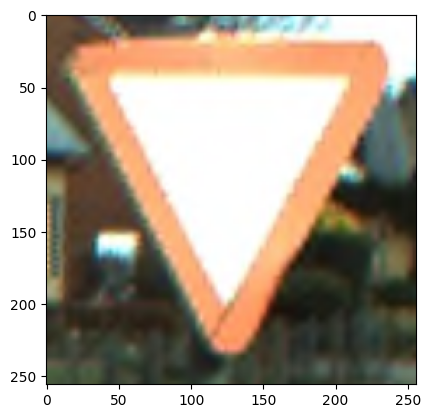

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 100.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

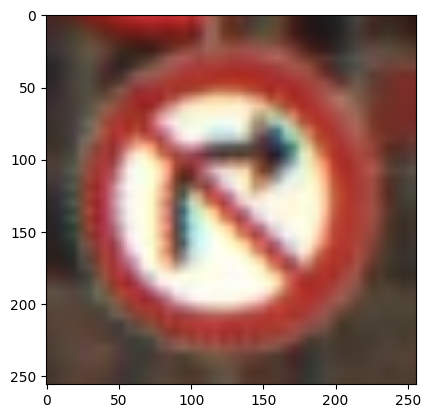

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.3%
13) 00028 => Softmax Output: 0.6%
14) 00029 => Softmax Output: 2.1%
15) 00030 => Softmax Output: 2.5%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 94.4%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

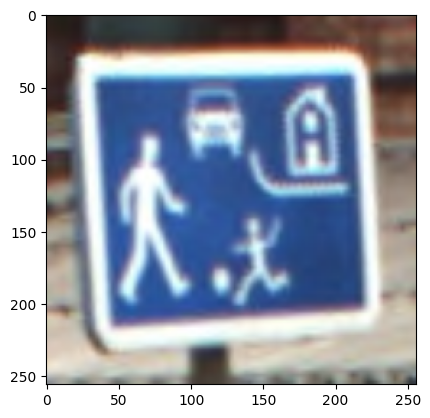

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax 

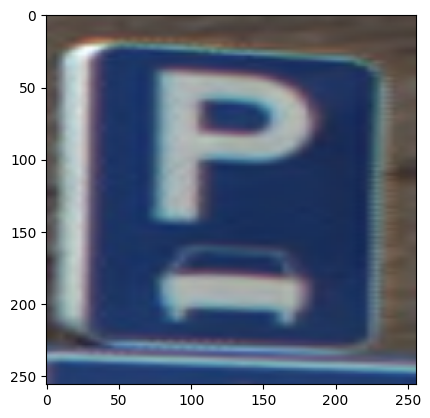

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 100.0%
28) 00051 => Softma

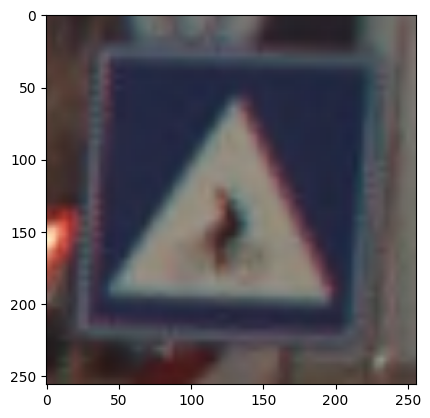

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax 

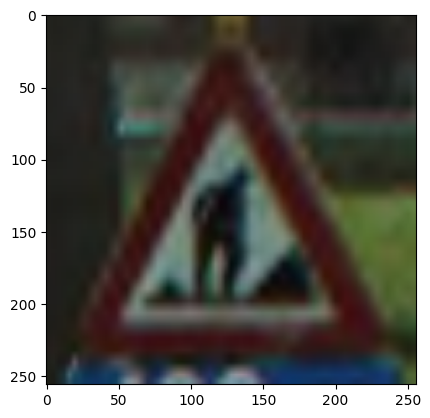

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.2%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 99.4%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.3%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

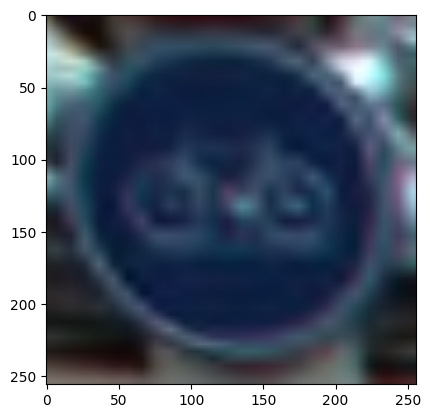

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 100.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

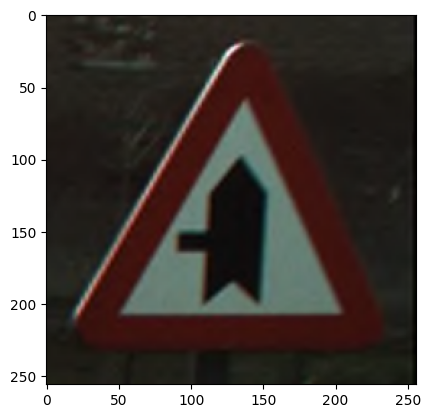

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 100.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

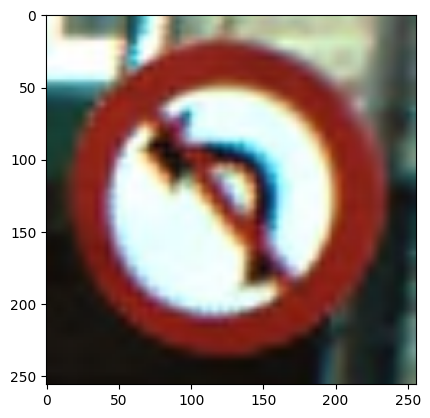

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 1.3%
14) 00029 => Softmax Output: 98.6%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.1%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

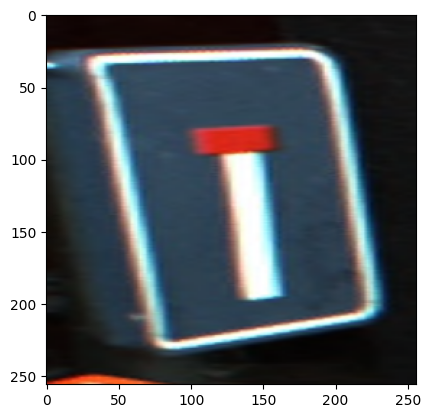

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax 

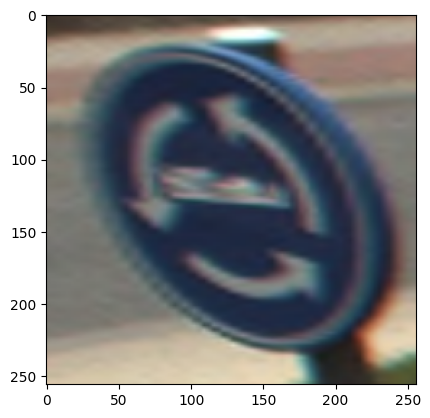

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.1%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 98.8%
21) 00038 => Softmax Output: 0.4%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.1%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

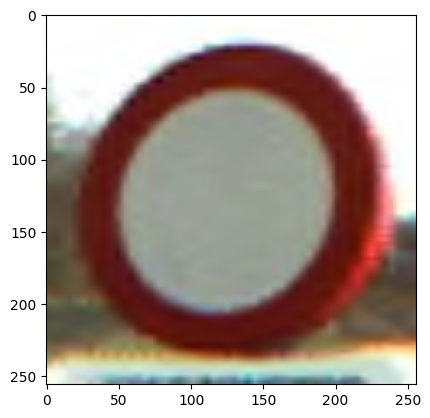

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 100.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

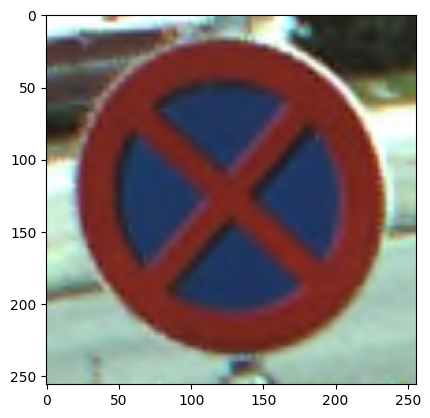

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 100.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

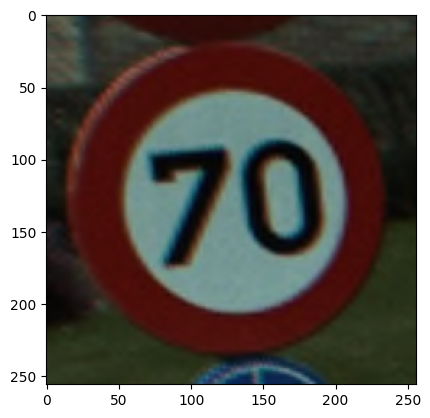

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 100.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

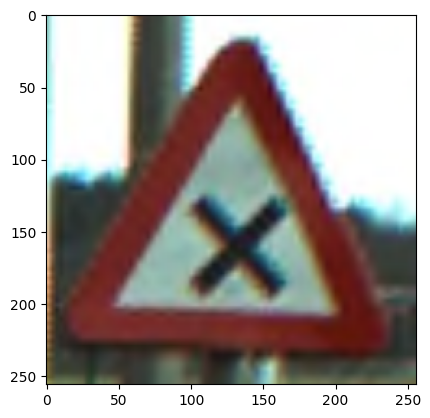

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 100.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

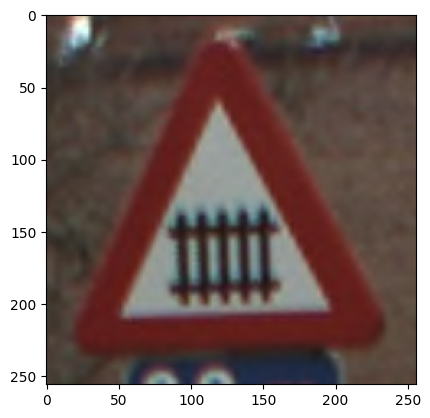

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.1%
2) 00005 => Softmax Output: 0.1%
3) 00007 => Softmax Output: 0.1%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 96.1%
7) 00013 => Softmax Output: 0.1%
8) 00017 => Softmax Output: 0.9%
9) 00018 => Softmax Output: 2.7%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

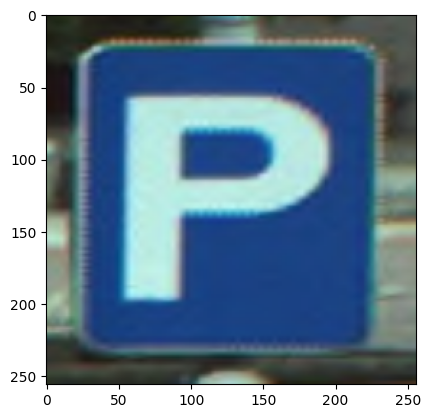

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 100.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

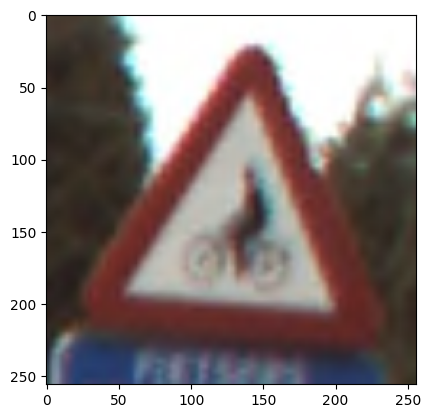

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.8%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 48.8%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 50.3%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

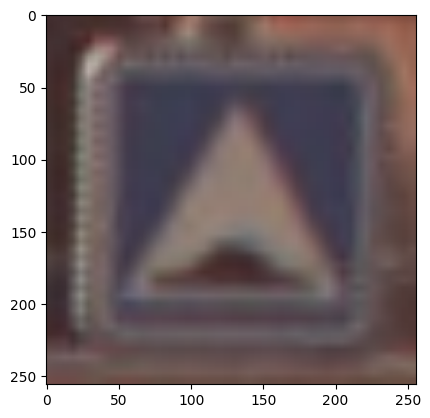

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax 

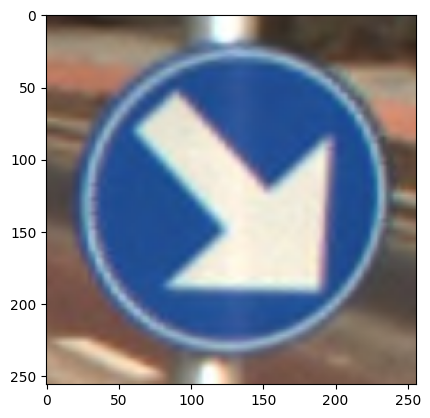

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.4%
19) 00035 => Softmax Output: 99.6%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

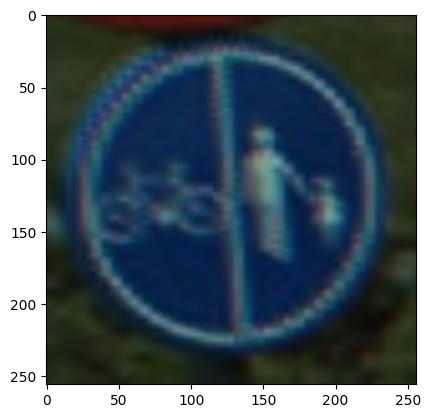

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 100.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

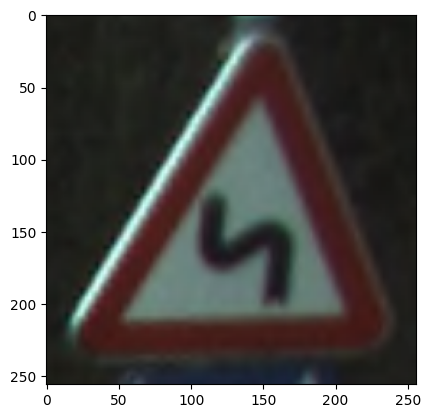

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 10.2%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.5%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 1.0%
8) 00017 => Softmax Output: 88.1%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

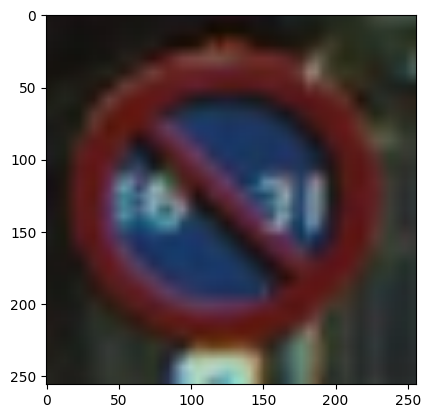

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 3.4%
25) 00043 => Softmax Output: 96.6%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softmax

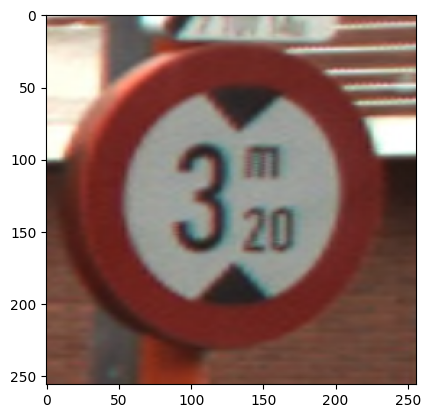

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 0.0%
12) 00027 => Softmax Output: 82.2%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 17.7%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

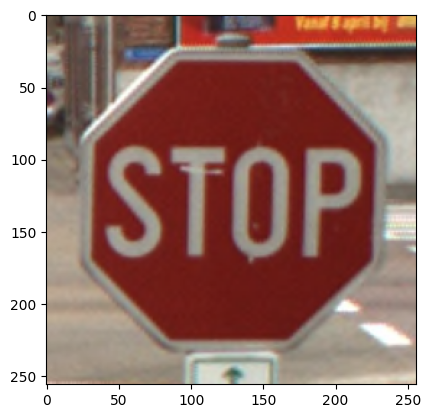

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

There are 34 possible classes:
1) 00004 => Softmax Output: 0.0%
2) 00005 => Softmax Output: 0.0%
3) 00007 => Softmax Output: 0.0%
4) 00008 => Softmax Output: 0.0%
5) 00010 => Softmax Output: 0.0%
6) 00012 => Softmax Output: 0.0%
7) 00013 => Softmax Output: 0.0%
8) 00017 => Softmax Output: 0.0%
9) 00018 => Softmax Output: 0.0%
10) 00019 => Softmax Output: 0.0%
11) 00021 => Softmax Output: 100.0%
12) 00027 => Softmax Output: 0.0%
13) 00028 => Softmax Output: 0.0%
14) 00029 => Softmax Output: 0.0%
15) 00030 => Softmax Output: 0.0%
16) 00031 => Softmax Output: 0.0%
17) 00032 => Softmax Output: 0.0%
18) 00034 => Softmax Output: 0.0%
19) 00035 => Softmax Output: 0.0%
20) 00037 => Softmax Output: 0.0%
21) 00038 => Softmax Output: 0.0%
22) 00039 => Softmax Output: 0.0%
23) 00041 => Softmax Output: 0.0%
24) 00042 => Softmax Output: 0.0%
25) 00043 => Softmax Output: 0.0%
26) 00045 => Softmax Output: 0.0%
27) 00047 => Softmax Output: 0.0%
28) 00051 => Softma

In [ ]:
from keras.utils import load_img, img_to_array

print('### Result Visualization ###')
print()

# Load saved model
model = tf.keras.models.load_model('/content/my_model_pre.keras')

correct_pred = 0
test_folders = os.listdir(test_dir)
for folder in test_folders:
    img_path = os.path.join(test_dir,folder)
    test_files = os.listdir(img_path)
    img_path = os.path.join(img_path, test_files[0])

    print('The image below has been input to the produced model:')
    print()

    img = load_img(img_path, target_size=(input_img, input_img),  interpolation='bilinear')
    plt.imshow(img)
    plt.show()

    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    classes_pred = model.predict(x)
    classes = list(test_generator.class_indices.keys())
    print()
    print('There are %d possible classes:' % total_classes)

    for i in range(total_classes):
        print(f'{i+1}) {classes[i]} => Softmax Output: {round(100 * classes_pred[0][i],3)}%')

    pred_class = classes[classes_pred.argmax()]
    print(f'\n\n{img_path} is a {pred_class}\n\n')
    if pred_class == folder:
      correct_pred +=1

success_rate = correct_pred / len(test_folders)
print()
print('<<====== Prediction Accuracy ======>>')
print('- Correctly Classified: %d' % correct_pred)
print('- Total Images: %d' % len(test_folders))
print('- Success Rate: %.3f => %.1f%%' % (success_rate, 100 * success_rate))